In [1]:
# Cell 1 — Install (optional) and imports
# Run this cell first. xgboost install only if you want to use XGBoost (optional).
!pip install --quiet xgboost openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Cell 2 — Load dataset (for Colab)
# Option A: Use the uploaded file in the Colab session via files.upload()
from google.colab import files
uploaded = files.upload()  # run and choose your `animal_disease_dataset.xlsx`
import io
df = pd.read_excel(io.BytesIO(list(uploaded.values())[0]), engine='openpyxl')

# Option B (if the file is already in drive or path):
# df = pd.read_excel('/path/to/animal_disease_dataset.xlsx', engine='openpyxl')

print("Shape:", df.shape)
df.head()


Saving animal_disease_dataset.xlsx to animal_disease_dataset.xlsx
Shape: (43778, 7)


,Animal,Age,Temperature,Symptom 1,Symptom 2,Symptom 3,Disease
0,cow,3,103.1,depression,painless lumps,loss of appetite,pneumonia
1,buffalo,13,104.5,painless lumps,loss of appetite,depression,lumpy virus
2,sheep,1,100.5,depression,painless lumps,loss of appetite,lumpy virus
3,cow,14,100.3,loss of appetite,swelling in limb,crackling sound,blackleg
4,sheep,2,103.6,painless lumps,loss of appetite,depression,pneumonia


In [3]:
# Cell 3 — Quick EDA
print("Columns:", df.columns.tolist())
print("\nValue counts for Disease (target):")
print(df['Disease'].value_counts())

print("\nSample types:")
print(df.dtypes)

# Check missing values
print("\nMissing (% per column):")
print((df.isnull().mean()*100).round(2))

# quick distribution of age/temperature
display(df[['Age','Temperature']].describe())


Columns: ['Animal', 'Age', 'Temperature', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Disease']

Value counts for Disease (target):
Disease
anthrax           9842
blackleg          9713
foot and mouth    9701
pneumonia         7330
lumpy virus       7192
Name: count, dtype: int64

Sample types:
Animal          object
Age              int64
Temperature    float64
Symptom 1       object
Symptom 2       object
Symptom 3       object
Disease         object
dtype: object

Missing (% per column):
Animal         0.0
Age            0.0
Temperature    0.0
Symptom 1      0.0
Symptom 2      0.0
Symptom 3      0.0
Disease        0.0
dtype: float64


,Age,Temperature
count,43778.000000,43778.000000
mean,6.769131,102.269590
std,3.886739,1.400872
min,1.000000,100.000000
25%,4.000000,101.100000
50%,7.000000,102.200000
75%,10.000000,103.400000
max,15.000000,105.000000


In [4]:
# Cell 4 — Preprocessing: Build features
# Approach:
# - Animal: one-hot
# - Age: numeric (you can bucketize later)
# - Temperature: numeric
# - Symptoms: treat the 3 symptom columns as multi-label -> combine into set and multi-hot via MultiLabelBinarizer

# Create symptom list column
symptom_cols = ['Symptom 1', 'Symptom 2', 'Symptom 3']
def combine_symptoms(row):
    # keep unique non-null symptoms
    s = [str(row[c]).strip().lower() for c in symptom_cols if pd.notnull(row[c])]
    # remove generic 'nan' if present
    s = [x for x in s if x not in ('nan','none','nan.')]
    return list(dict.fromkeys(s))  # unique preserve order

df['symptom_list'] = df.apply(combine_symptoms, axis=1)

# Inspect top symptoms
from collections import Counter
all_symptoms = Counter([sym for sub in df['symptom_list'] for sym in sub])
print("Top symptoms:", all_symptoms.most_common(20))

# MultiLabelBinarizer for symptoms
mlb = MultiLabelBinarizer(sparse_output=False)
symptom_multi = mlb.fit_transform(df['symptom_list'])
symptom_feature_names = [f"symptom__{s}" for s in mlb.classes_]
symptom_df = pd.DataFrame(symptom_multi, columns=symptom_feature_names)

# One-hot for Animal
animal_ohe = pd.get_dummies(df['Animal'].astype(str).str.lower(), prefix='animal')

# Build final feature dataframe
X = pd.concat([
    df[['Age','Temperature']].reset_index(drop=True),
    animal_ohe.reset_index(drop=True),
    symptom_df.reset_index(drop=True)
], axis=1)

# Target label encode
le = LabelEncoder()
y = le.fit_transform(df['Disease'].astype(str).str.lower())

print("Feature matrix shape:", X.shape)
print("Number of classes:", len(le.classes_))
print("Classes:", le.classes_)


Top symptoms: [('loss of appetite', 30098), ('depression', 20334), ('painless lumps', 14522), ('difficulty walking', 7805), ('lameness', 7678), ('crackling sound', 5886), ('fatigue', 4982), ('shortness of breath', 4977), ('sweats', 4926), ('chest discomfort', 4924), ('chills', 4846), ('swelling in muscle', 2985), ('swelling in limb', 2799), ('swelling in abdomen', 1680), ('swelling in extremities', 1624), ('swelling in neck', 1567), ('sores on tongue', 1258), ('sores on gums', 1252), ('blisters on hooves', 1227), ('sores on mouth', 1221)]
Feature matrix shape: (43778, 30)
Number of classes: 5
Classes: ['anthrax' 'blackleg' 'foot and mouth' 'lumpy virus' 'pneumonia']


In [5]:
# Cell 5 — Train/test split and scaling numeric features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Scale Age and Temperature
num_cols = ['Age','Temperature']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (35022, 30) Test shape: (8756, 30)


In [6]:
# Cell 6 — Train Random Forest baseline
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Random Forest accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Random Forest accuracy: 0.8000228414801279

Classification report:
                 precision    recall  f1-score   support

       anthrax       1.00      1.00      1.00      1969
      blackleg       1.00      1.00      1.00      1943
foot and mouth       1.00      1.00      1.00      1940
   lumpy virus       0.39      0.39      0.39      1438
     pneumonia       0.40      0.40      0.40      1466

      accuracy                           0.80      8756
     macro avg       0.76      0.76      0.76      8756
  weighted avg       0.80      0.80      0.80      8756



In [7]:
# Cell 7 — (Optional) Train XGBoost for comparison (will use installed xgboost)
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification report (XGBoost):\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))


XGBoost accuracy: 0.8040201005025126

Classification report (XGBoost):
                 precision    recall  f1-score   support

       anthrax       1.00      1.00      1.00      1969
      blackleg       1.00      1.00      1.00      1943
foot and mouth       1.00      1.00      1.00      1940
   lumpy virus       0.40      0.40      0.40      1438
     pneumonia       0.42      0.42      0.42      1466

      accuracy                           0.80      8756
     macro avg       0.76      0.76      0.76      8756
  weighted avg       0.80      0.80      0.80      8756



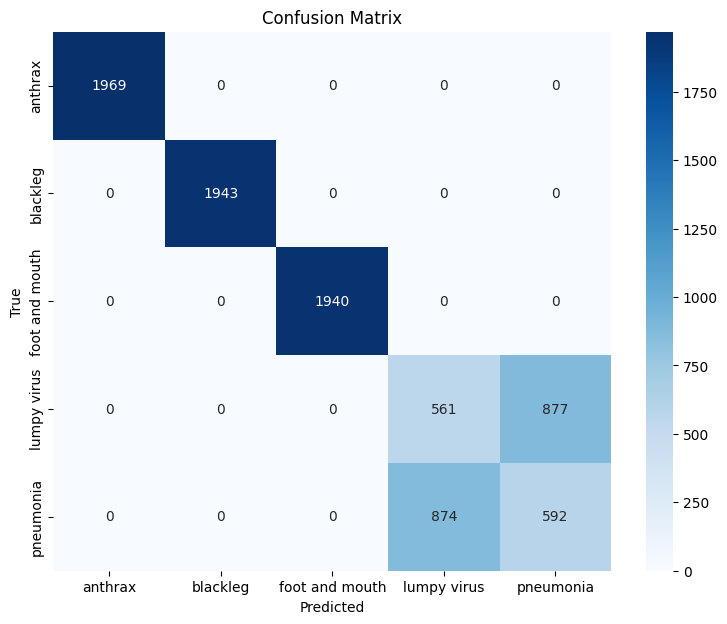

In [8]:
# Cell 8 — Confusion matrix visualization (for best model)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

best_model = rf  # choose between rf or xgb_clf depending on which performed better

cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [9]:
# Cell 9 — Save the best model and encoders/scaler/label encoder/mlb
model_artifacts = {
    "model": best_model,
    "scaler": scaler,
    "label_encoder": le,
    "mlb": mlb,
    "symptom_feature_names": symptom_feature_names,
    "animal_columns": animal_ohe.columns.tolist(),
}

joblib.dump(model_artifacts, 'livestock_health_model_artifacts.joblib')
print("Saved model artifacts to livestock_health_model_artifacts.joblib")


Saved model artifacts to livestock_health_model_artifacts.joblib


In [10]:
# Cell 10 — Download the model file from Colab to your local machine
from google.colab import files
files.download('livestock_health_model_artifacts.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Cell 11 — Helper: function to run a prediction for a single new record
# Provide values as a dict: {'Animal': 'cow', 'Age': 4, 'Temperature': 103.5, 'symptoms': ['loss of appetite','depression']}
def predict_disease(record, artifacts_path='livestock_health_model_artifacts.joblib'):
    artifacts = joblib.load(artifacts_path)
    model = artifacts['model']
    scaler = artifacts['scaler']
    le = artifacts['label_encoder']
    mlb = artifacts['mlb']
    symptom_names = artifacts.get('symptom_feature_names', [])
    animal_cols = artifacts.get('animal_columns', [])

    # prepare features
    animal = record.get('Animal','').lower()
    age = record.get('Age', np.nan)
    temp = record.get('Temperature', np.nan)
    symptoms = [s.strip().lower() for s in record.get('symptoms', [])]

    # build symptom row
    sym_arr = mlb.transform([symptoms]) if hasattr(mlb, 'classes_') else np.zeros((1, len(symptom_names)))
    sym_df = pd.DataFrame(sym_arr, columns=symptom_names)

    # animal one-hot
    animal_row = {c:0 for c in animal_cols}
    col_name = f"animal_{animal}"
    if col_name in animal_row:
        animal_row[col_name] = 1

    feat = pd.DataFrame([{
        'Age': age,
        'Temperature': temp,
        **animal_row
    }])
    sym_df = sym_df.reset_index(drop=True)
    Xnew = pd.concat([feat.reset_index(drop=True), sym_df], axis=1)
    # ensure missing columns present
    for c in model.feature_names_in_:
        if c not in Xnew.columns:
            Xnew[c] = 0
    # order columns
    Xnew = Xnew[model.feature_names_in_]
    # scale numeric
    Xnew[['Age','Temperature']] = scaler.transform(Xnew[['Age','Temperature']])

    pred_idx = model.predict(Xnew)[0]
    pred_label = le.inverse_transform([pred_idx])[0]
    probs = None
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(Xnew)[0]
        class_probs = dict(zip(le.classes_, probs))
    else:
        class_probs = None

    return {"predicted_disease": pred_label, "class_probs": class_probs}

# Example usage:
example = {'Animal':'cow','Age':3,'Temperature':103.1,'symptoms':['depression','loss of appetite']}
print(predict_disease(example, artifacts_path='livestock_health_model_artifacts.joblib'))


{'predicted_disease': 'blackleg', 'class_probs': {'anthrax': np.float64(0.0), 'blackleg': np.float64(0.95), 'foot and mouth': np.float64(0.0), 'lumpy virus': np.float64(0.028900657866849113), 'pneumonia': np.float64(0.021099342133150886)}}
